# EDA

**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

**Loading dataset:**

In [2]:
import kaggle
kaggle.api.authenticate() 
kaggle.api.dataset_download_files('blastchar/telco-customer-churn', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn


In [3]:
data = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

There are no NaN, but there are many categorical features. `customerID` consists of unique values - **delete it**. `TotalCharges` is defined as an object, but contains numeric data - **re-encode**.

In [6]:
data.drop('customerID', axis=1, inplace=True)

In [7]:
data['TotalCharges'] = data['TotalCharges'].replace(' ', '')
data = data.replace(r'^\s*$', np.nan, regex=True)
data['TotalCharges'] = data['TotalCharges'].astype('float64')

In [8]:
data.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
data = data.dropna()

DE-coding `SeniorCitizen` column

In [10]:
data['SeniorCitizen'] = data['SeniorCitizen'].replace(0, 'No')
data['SeniorCitizen'] = data['SeniorCitizen'].replace(1, 'Yes')

data['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

## Services popularity

In [11]:
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'StreamingMovies',
            'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'PaperlessBilling']

data_services = data.copy()

data_services[services] = data_services[services].replace({'No': 0,
                                                           'Yes': 1,
                                                           'No phone service': 0,
                                                           'Fiber optic': 1,
                                                           'DSL': 1,
                                                           'No internet service': 0})

data['sum_of_services'] = data_services[services].sum(axis=1)

data['sum_of_months'] = data['TotalCharges'] / data['MonthlyCharges']
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,sum_of_services,sum_of_months
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,3,1.000000
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,No,4,33.178227
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,5,2.008357
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,4,43.516548
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,3,2.144979


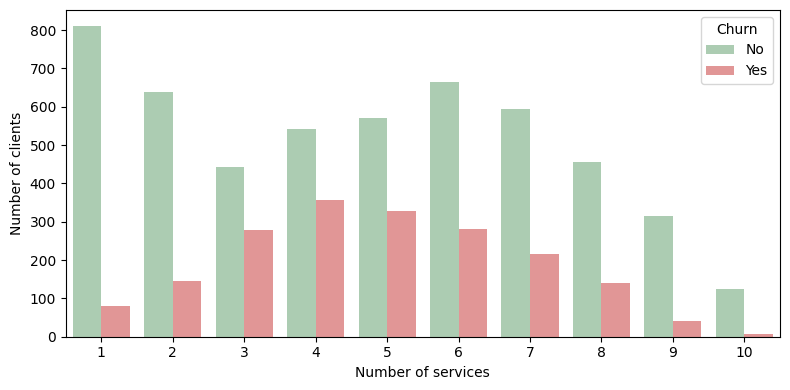

In [12]:
plt.figure(figsize=[8, 4])

sns.countplot(data=data,
              x='sum_of_services',
              hue='Churn',
              palette=['#a7d1ae', '#ed8a8a'])
plt.xlabel('Number of services')
plt.ylabel('Number of clients')

plt.tight_layout()
plt.show()

Clients who have about 3-6 services most often churn.

## Distribution of features

In [13]:
data_dist = data.copy()
data_dist.drop(['tenure', 'MonthlyCharges', 'TotalCharges',
                'sum_of_months', 'sum_of_services'],
                axis=1, inplace=True)

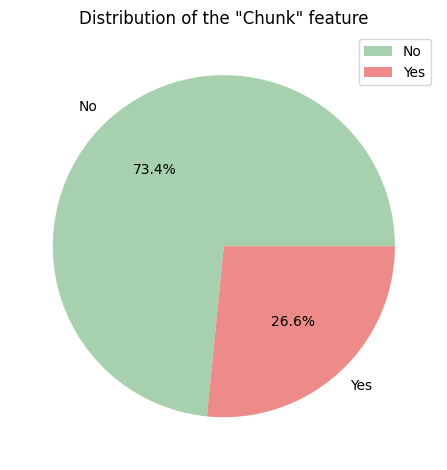

In [14]:
plt.pie(data_dist['Churn'].value_counts(),
        autopct='%1.1f%%',
        labels=data_dist['Churn'].unique(),
        colors=['#a7d1ae', '#ed8a8a'])

plt.title('Distribution of the "Chunk" feature')
plt.legend()
plt.tight_layout()
plt.show()

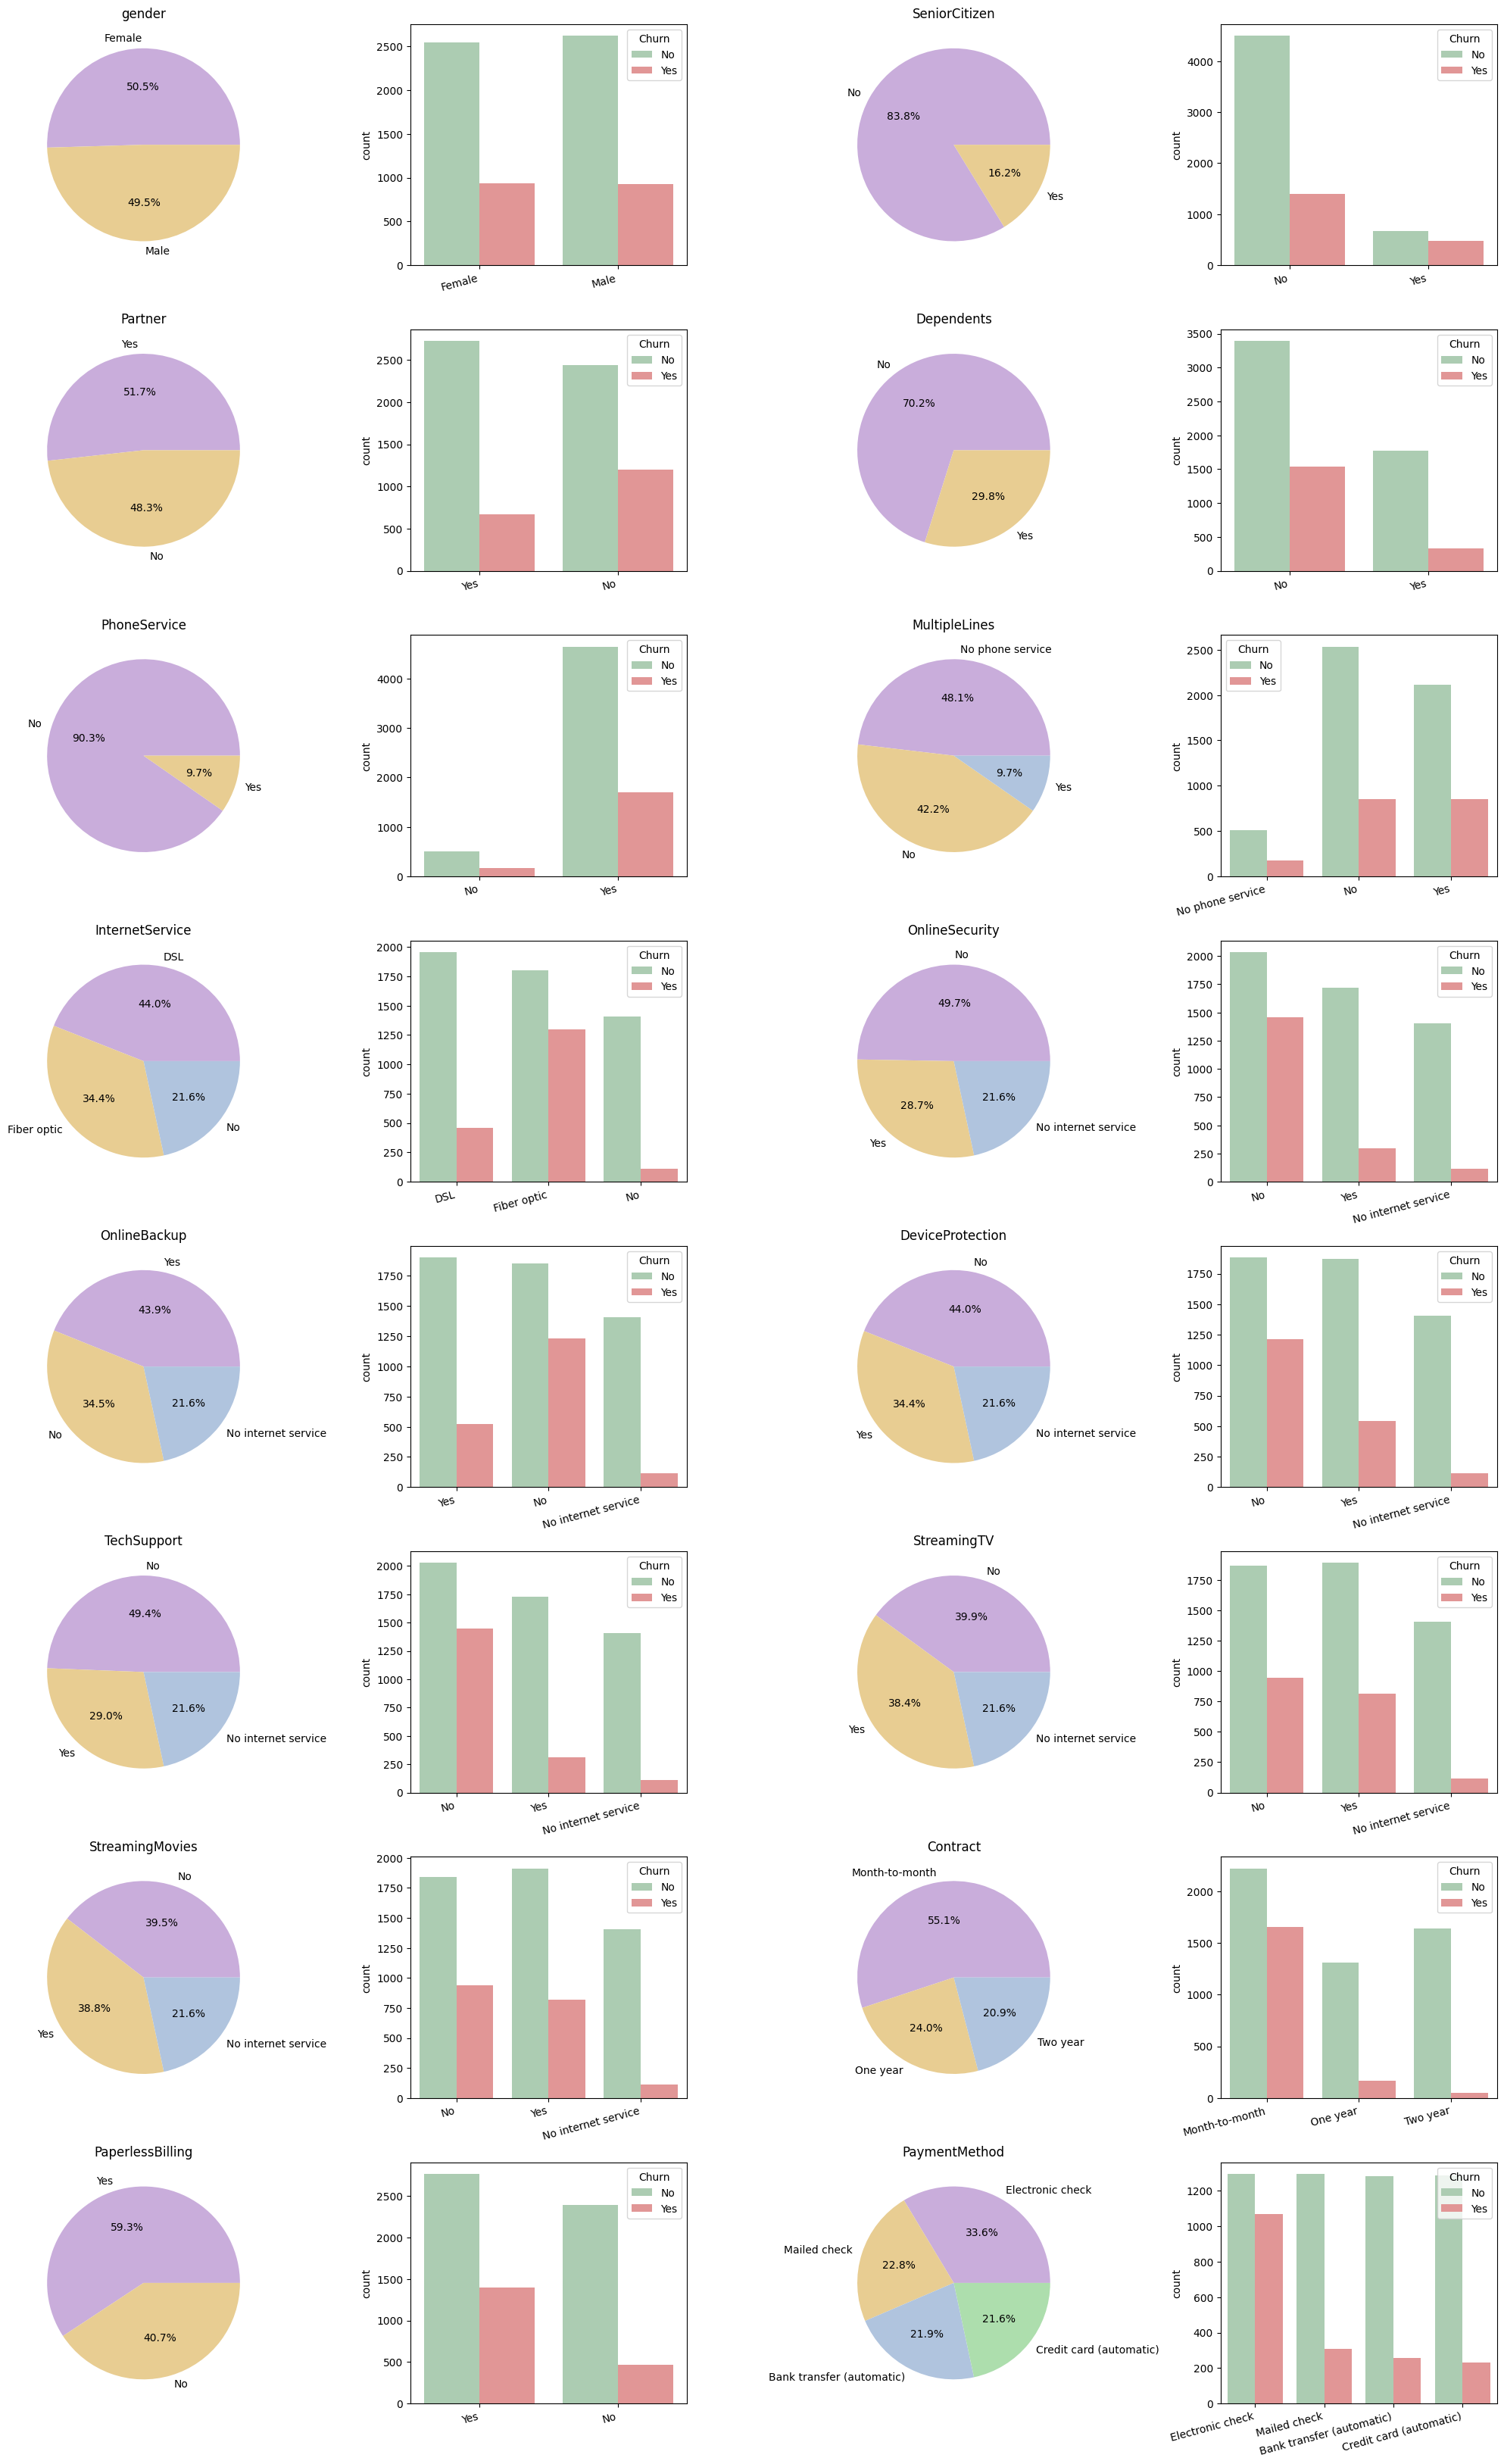

In [15]:
plt.figure(figsize=(20, 40))

for i, col in enumerate(data_dist.iloc[:, :-1]):
    plt.subplot(10, 4, i*2+1)
    
    plt.title(col)
    plt.pie(data_dist[col].value_counts(),
            autopct='%1.1f%%', labels=data_dist[col].unique(),
            colors=['#c9addb', '#e8cd92', '#B0C4DE', '#addead'])
    
    plt.subplot(10, 4, i*2+2)
    sns.countplot(data=data_dist,
                  x=col,
                  hue='Churn',
                  palette=['#a7d1ae', '#ed8a8a'])
    plt.xticks(rotation=15, ha='right')
    plt.xlabel('')

plt.tight_layout()
plt.show()

- `gender` - gender does not affect the client's decision
- `Senior Citizen` - older people are more likely to refuse services
- `Partner` & `Dependents` - clients in relationships, as well as clients with children, are less likely to refuse services. Perhaps the company will present favorable family tariffs
- `InternetService` - customers with fiber optic more often refuse services. Customers who do not use the Internet very rarely refuse
- `OnlineSecurity`, `OnlineBackup` & `DeviceProtection` - clients who use protection systems, as well as those who use cloud storage, are more likely to refuse. Competitors also have favorable package offers with additional services
- `TechSupport` -  customers who do not contact technical support are more likely to refuse
- `Contract` - logical, clients with a short-term contract leave more often
- `PaperlessBilling` & `PaperlessBilling` - customers who receive and pay bills in a conservative way are less likely to change service providers

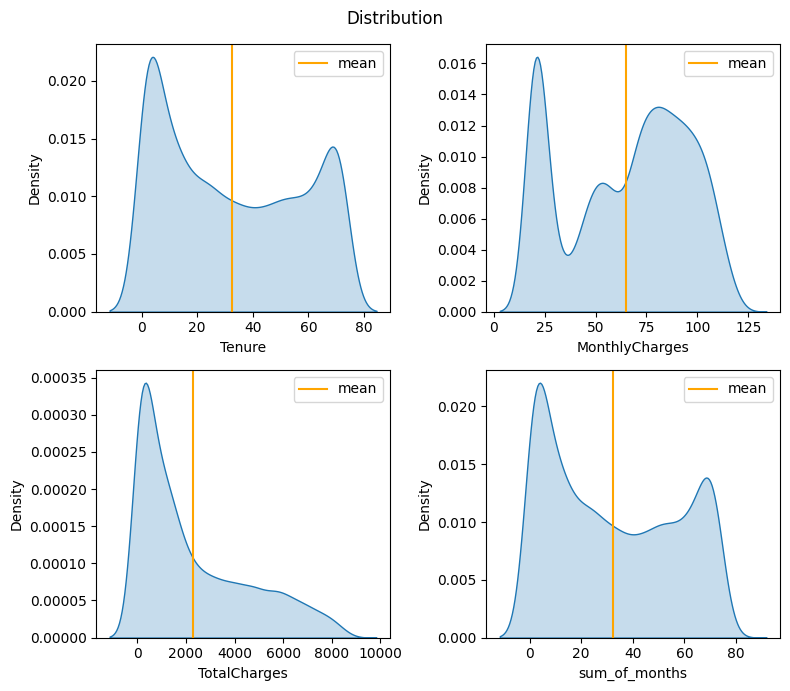

In [16]:
plt.figure(figsize=[8, 7])
plt.suptitle('Distribution')

plt.subplot(2, 2, 1)
sns.kdeplot(data['tenure'], fill=True)
plt.xlabel('Tenure')
plt.ylabel('Density')
plt.axvline(data['tenure'].mean(), label='mean', c='orange')
plt.legend()

plt.subplot(2, 2, 2)
sns.kdeplot(data['MonthlyCharges'], fill=True)
plt.xlabel('MonthlyCharges')
plt.ylabel('Density')
plt.axvline(data['MonthlyCharges'].mean(), label='mean', c='orange')
plt.legend()

plt.subplot(2, 2, 3)
sns.kdeplot(data['TotalCharges'], fill=True)
plt.xlabel('TotalCharges')
plt.ylabel('Density')
plt.axvline(data['TotalCharges'].mean(), label='mean', c='orange')
plt.legend()

plt.subplot(2, 2, 4)
sns.kdeplot(data['sum_of_months'], fill=True)
plt.xlabel('sum_of_months')
plt.ylabel('Density')
plt.axvline(data['sum_of_months'].mean(), label='mean', c='orange')
plt.legend()

plt.tight_layout()
plt.show()

## Label Encoder

In [17]:
data_code = data.copy()
data_code.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1, inplace=True)

In [18]:
le = LabelEncoder()
data_code = data_code.apply(lambda x: le.fit_transform(x))

In [19]:
data_code[['tenure', 'MonthlyCharges', 'TotalCharges']] = data[['tenure', 'MonthlyCharges', 'TotalCharges']]
data_code.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,sum_of_services,sum_of_months,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,0,2,0,...,0,0,1,2,0,2,0,1,29.85,29.85
1,1,0,0,0,1,0,0,2,0,2,...,0,1,0,3,0,3,3207,34,56.95,1889.50
2,1,0,0,0,1,0,0,2,2,0,...,0,0,1,3,1,4,134,2,53.85,108.15
3,1,0,0,0,0,1,0,2,0,2,...,0,1,0,0,0,3,3856,45,42.30,1840.75
4,0,0,0,0,1,0,1,0,0,0,...,0,0,1,2,1,2,189,2,70.70,151.65


## Correlation

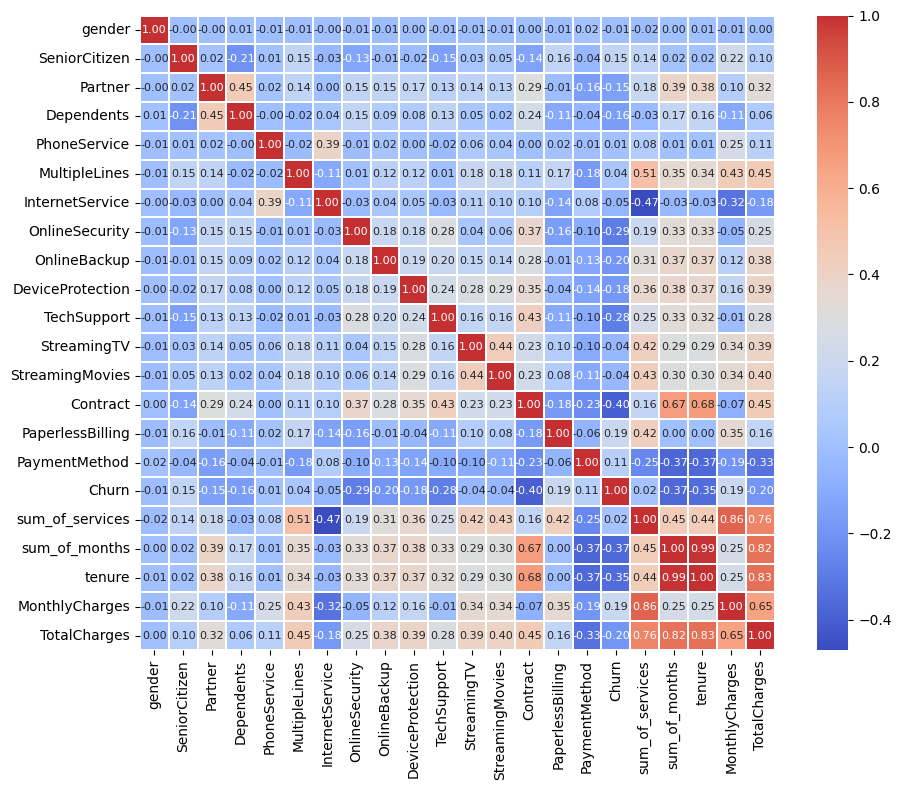

In [20]:
plt.figure(figsize=[10, 8])
sns.heatmap(data_code.corr(), annot=True , fmt = '.2f', annot_kws={"fontsize": 8},
            linewidths=0.25, center= 0.3, cmap= 'coolwarm', square=True)

plt.tight_layout()
plt.show()

In [21]:
data.drop('sum_of_months', axis=1, inplace=True)

# Models

In [22]:
def report(pred, actual):
    accuracy = round(accuracy_score(pred, actual), 4)
    precision = round(precision_score(pred, actual), 4)
    recall = round(recall_score(pred, actual), 4)
    f1 = round(f1_score(pred, actual), 4)
    
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nf1_score: {f1}')

In [23]:
y = data_code['Churn']
X = data_code.drop('Churn', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    stratify=data['Churn'],
                                                    random_state=RANDOM_SEED)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4922, 21), (2110, 21), (4922,), (2110,))

## CatBoost

In [24]:
cat_model = CatBoostClassifier(verbose=False,
                               random_state=RANDOM_SEED,
                               custom_loss=['AUC', 'Accuracy',  'Precision', 'Recall', 'F1'])
cat_model.fit(X_train, y_train,
              eval_set=(X_test, y_test),
              plot=True)

y_train_cb = cat_model.predict(X_train)
y_test_cb = cat_model.predict(X_test)

print("Train quality:")
report(y_train_cb, y_train)
print("\nTest quality:")
report(y_test_cb, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train quality:
Accuracy: 0.8314
Precision: 0.5787
Recall: 0.7307
f1_score: 0.6459

Test quality:
Accuracy: 0.7886
Precision: 0.4938
Recall: 0.631
f1_score: 0.554


In [25]:
print(cat_model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'Logloss', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': True, 'class_names': [0, 1], 'random_seed': 42, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'custom_metric': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'], 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rat

- After the 92nd iteration, overfitting begins, the logloss value is 0.42.
- The AUC value at the 108th iteration is 0.8373. After about the 300th iteration the AUC value less than 0.8.
- Max value of accuracy at the 330th iteration (0.79). Also at about 50-500 iterations the value is around 0.79, then decreases slightly.
- The maximum value of precision is fixed at the 7th iteration (0.66), during the first 500 iterations it is around 0.63, then drops rapidly.
- The value of the recall at the 450th iteration is 0.52.
- The F1-score at the 479th iteration is 0.57.

Default value:
- `Learning Rate` - 0.04697500169277191
- `subsample` - 0.800000011920929
- `depth` - 6
- `min_data_in_leaf` - 1
- `max_leaves` - 64

Obviously, 1000 default iterations is too much for this data. It semms the optimal number is no more than **500**
<br/> Since the model is clearly prone to overfitting, the `Learning Rate` is optimal in the range **[0.01, 0.02, 0.03, 0.04, 0.05]**

**What does Optuna think about this?**

### Tuning CatBoost with Optuna

In [26]:
def objective(trial):
    params = {'loss_function': 'Logloss',
              'iterations': trial.suggest_int('iterations', 100, 1000),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'depth': trial.suggest_int('depth', 1, 16),
              'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 100),
              'border_count': trial.suggest_int('border_count', 1, 300),
              'task_type': 'CPU',
              'random_seed': RANDOM_SEED}

    cat_model = CatBoostClassifier(**params, verbose=0)

    score = np.mean(cross_val_score(cat_model, X_train, y_train, cv=7,
                                    scoring='accuracy'))
    return score

In [27]:
sampler=optuna.samplers.TPESampler()

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=-1)
best_params_cat = study.best_params
best_params_cat

{'iterations': 727,
 'learning_rate': 0.014171919959709426,
 'depth': 3,
 'l2_leaf_reg': 22.956759657523328,
 'border_count': 164}

In [27]:
best_params_cat = {
    'iterations': 727,
    'learning_rate': 0.014171919959709426,
     'depth': 3,
    'l2_leaf_reg': 22.956759657523328,
    'border_count': 164
    }

In [28]:
cat_model = CatBoostClassifier(**best_params_cat, verbose=False)
cat_model.fit(X_train, y_train)

y_train_cb = cat_model.predict(X_train)
y_test_cb = cat_model.predict(X_test)

print("Train quality:")
report(y_train_cb, y_train)
print("\nTest quality:")
report(y_test_cb, y_test)

Train quality:
Accuracy: 0.8194
Precision: 0.5635
Recall: 0.6986
f1_score: 0.6238

Test quality:
Accuracy: 0.7929
Precision: 0.4991
Recall: 0.6422
f1_score: 0.5617


#### Cross Valivation

In [29]:
parameters = {**best_params_cat}
parameters['loss_function'] = 'Logloss'
parameters['verbose'] = False
parameters['custom_loss'] = ['AUC', 'Accuracy',  'Precision', 'Recall', 'F1']

parameters

{'iterations': 727,
 'learning_rate': 0.014171919959709426,
 'depth': 3,
 'l2_leaf_reg': 22.956759657523328,
 'border_count': 164,
 'loss_function': 'Logloss',
 'verbose': False,
 'custom_loss': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']}

In [30]:
cv_data = cv(params=parameters,
             pool=Pool(X, label=y),
             fold_count=5,
             shuffle=True,
             partition_random_seed=RANDOM_SEED,
             verbose=False,
             stratified=True,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4080593597
bestIteration = 599

Training on fold [1/5]

bestTest = 0.3870013134
bestIteration = 624

Training on fold [2/5]

bestTest = 0.4126612384
bestIteration = 695

Training on fold [3/5]

bestTest = 0.4202394072
bestIteration = 699

Training on fold [4/5]

bestTest = 0.4261909616
bestIteration = 708



### Feature Importance

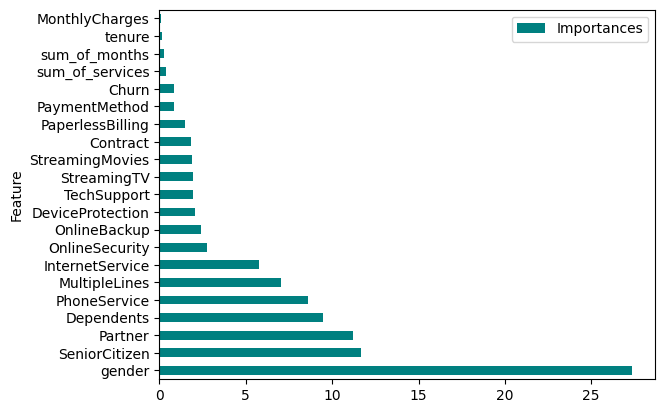

In [32]:
feature_df = cat_model.get_feature_importance(prettified=True)
feature_df = feature_df.rename(columns={'Feature Id': 'Feature'})

index = feature_df['Feature'].to_list()
index = list(map(int, index))

feature_df['Feature'][index] = data_code.columns[index]
feature_df = feature_df.set_index('Feature')

feature_df.plot.barh(color='teal')
plt.show()